# Importing Relevent Libraries

In [98]:
# for data visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for preprocessing
import pyspark.sql.functions as F
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.types import *
from pyspark.sql.functions import udf

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, StandardScaler, VectorAssembler

# for model building and evaluation
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

SEED = 0

StatementMeta(idssmall, 0, 98, Finished, Available)

# Load the dataset

In [99]:
df = spark.read.options(header='True', inferSchema='True').csv("abfss://idspyspark@idspyspark.dfs.core.windows.net/Train_data.csv")
print("Dataset has {} rows & {} columns".format(df.count(), len(df.columns)))

StatementMeta(idssmall, 0, 99, Finished, Available)

Dataset has 25192 rows & 42 columns

In [100]:
df.printSchema()

StatementMeta(idssmall, 0, 100, Finished, Available)

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

In [101]:
df.limit(5).toPandas()

StatementMeta(idssmall, 0, 101, Finished, Available)

   duration protocol_type  ... dst_host_srv_rerror_rate    class
0         0           tcp  ...                     0.00   normal
1         0           udp  ...                     0.00   normal
2         0           tcp  ...                     0.00  anomaly
3         0           tcp  ...                     0.01   normal
4         0           tcp  ...                     0.00   normal

[5 rows x 42 columns]

In [102]:
target_col = "class"
cate_cols = ["flag","protocol_type","service"]
num_cols = list(set(df.columns) - set(cate_cols) - set([target_col]))

StatementMeta(idssmall, 0, 102, Finished, Available)

# Data Analysis and Preprocessing

## Impute missing values

In [103]:
# Impute numerical features
for col in num_cols:
    df = df.withColumn(col, df[col].cast('double'))
    mu = df.select(col).agg({col:'mean'}).collect()[0][0]
    df = df.withColumn(col, F.when(df[col].isNull(), mu)\
                       .otherwise(df[col]))

# Impute categorical features
for col in cate_cols:
    frq = df.select(col).groupby(col).count()\
                        .orderBy('count', ascending=False) \
                        .limit(1).collect()[0][0]
    df = df.withColumn(col, F.when((df[col].isNull() | 
                                    (df[col] == '')), frq) \
                            .otherwise(df[col]))
# Encode target column
udf_class = udf(lambda x: 1 if x=="anomaly" else 0, IntegerType())
df = df.withColumn("class", udf_class("class"))

# Filter missing values
df = df.withColumn('label', df[target_col].cast('double'))
df = df.filter(df['label'].isNotNull())

StatementMeta(idssmall, 0, 103, Finished, Available)

In [104]:
# df.createOrReplaceTempView("network_traffic")
# spark.sql("SELECT duration from network_traffic").show()

StatementMeta(idssmall, 0, 104, Finished, Available)

## Exploratory Data Analysis
We plot various graphs to identify distributions, relationships or any pattern that is not visible by seeing raw data.

In [105]:
df_pandas = df.toPandas()

StatementMeta(idssmall, 0, 105, Finished, Available)

StatementMeta(idssmall, 0, 106, Finished, Available)

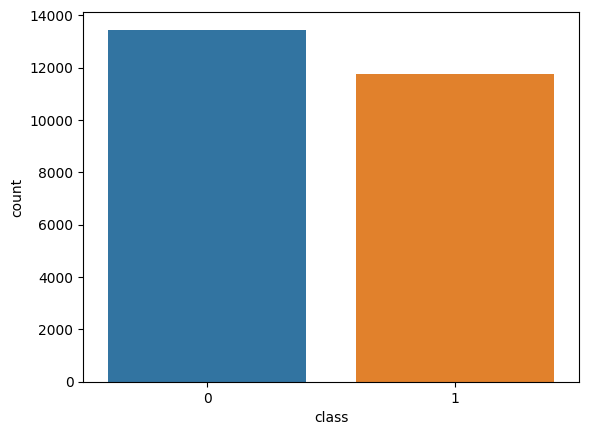

In [106]:
sns.countplot(x=df_pandas['class'])
plt.show()

StatementMeta(idssmall, 0, 107, Finished, Available)

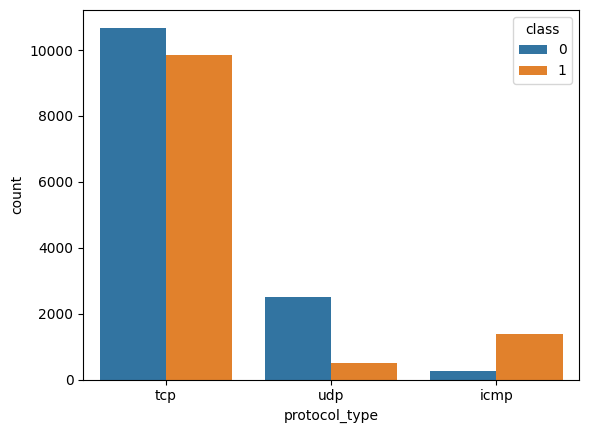

In [107]:
sns.countplot(x='protocol_type', data=df_pandas, hue="class")
plt.show()

StatementMeta(idssmall, 0, 108, Finished, Available)

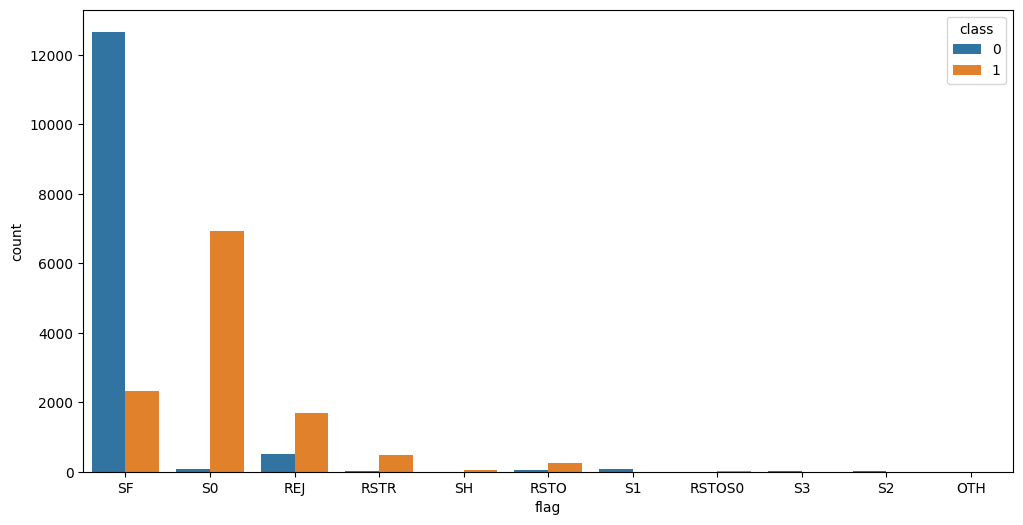

In [108]:
plt.figure(figsize=(12,6))
sns.countplot(x='flag', data=df_pandas, hue="class")
plt.show()

StatementMeta(idssmall, 0, 109, Finished, Available)

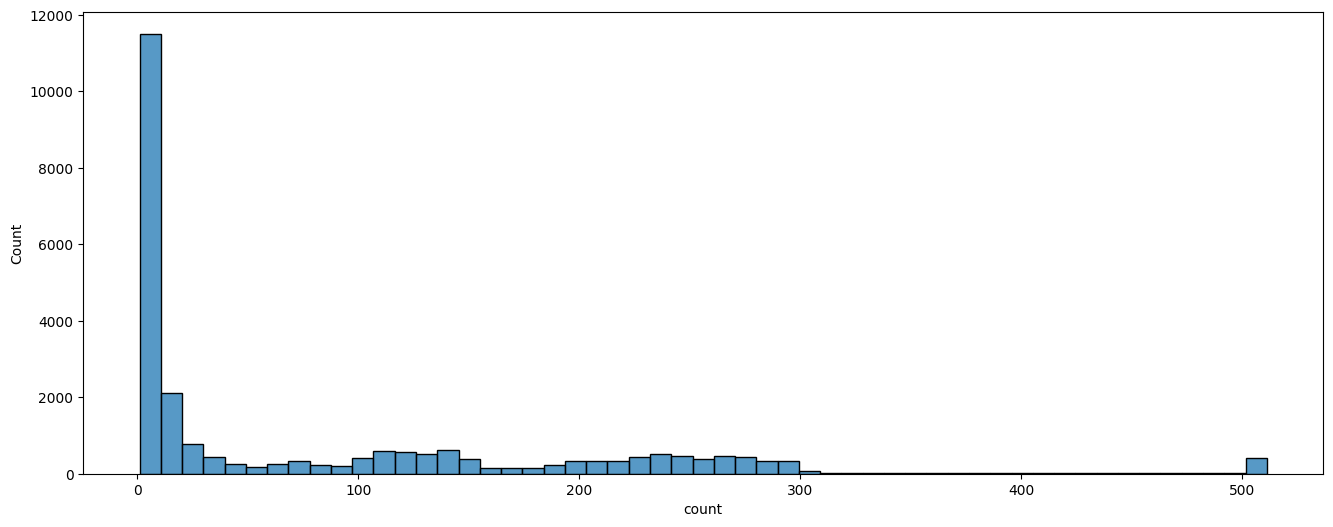

In [109]:
plt.figure(figsize=(16,6))
sns.histplot(df_pandas['count'])
plt.show()

### Observation from the analysis:
- We identified a slight imbalance in the target column "class" of our dataset. But it is not significant, otherwise we could go for oversampling.
- 80% of traffic belongs TCP while 12% belongs to UDP and rest to ICMP.
- Most of the ICMP traffic had anomaly; most of the UDP traffic was normal; while the distribution was almost equal in case of TCP.
- The traffic distribution on the basis of flags was also uneven where most of it had SF(Sign Flag).
- Most of the traffic with SF was normal, while that had S0 flag had anomaly.
- Most of the traffic recorded was unique.

## Data Encoding and Scaling

In [110]:
# helper function
def gen_preprocessor(df):
    # String Indexing for categorical features
    indexers = [StringIndexer(inputCol=col, 
                              outputCol="{}_idx".format(col),
                              handleInvalid="keep") \
                              for col in cate_cols]
    
    # One-hot encoding for categorical features
    encoders = [OneHotEncoder(inputCol="{}_idx".format(col), 
                              outputCol="{}_oh".format(col)) \
                              for col in cate_cols]

    # Concat Feature Columns
    assembler = VectorAssembler(inputCols = num_cols + \
                            ["{}_oh".format(col) for col in cate_cols], 
                            outputCol = "_features")
    
    # Standardize Features
    scaler = StandardScaler(inputCol='_features', 
                            outputCol='features')

    preprocessor = Pipeline(stages = indexers + encoders + \
                                     [assembler, scaler]).fit(df)

    return preprocessor

StatementMeta(idssmall, 0, 110, Finished, Available)

In [111]:
# Pre-Process
preprocessor = gen_preprocessor(df)   
df = preprocessor.transform(df)["features","label"]

StatementMeta(idssmall, 0, 111, Finished, Available)

In [112]:
df.printSchema()

StatementMeta(idssmall, 0, 112, Finished, Available)

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)

In [113]:
r1 = Correlation.corr(df, "features").head()
print("Pearson correlation matrix:\n" + str(r1[0]))

StatementMeta(idssmall, 0, 113, Finished, Available)

Pearson correlation matrix:
DenseMatrix([[ 1.00000000e+00, -9.80079955e-04,  1.27036813e-02, ...,
              -4.28998563e-04, -3.50268907e-04, -2.47672604e-04],
             [-9.80079955e-04,  1.00000000e+00,  6.24838616e-01, ...,
              -1.09216653e-02, -9.14550038e-03, -6.49518890e-03],
             [ 1.27036813e-02,  6.24838616e-01,  1.00000000e+00, ...,
              -8.81384396e-03, -7.19633062e-03, -5.08847318e-03],
             ...,
             [-4.28998563e-04, -1.09216653e-02, -8.81384396e-03, ...,
               1.00000000e+00, -9.72424916e-05, -6.87594605e-05],
             [-3.50268907e-04, -9.14550038e-03, -7.19633062e-03, ...,
              -9.72424916e-05,  1.00000000e+00, -5.61407500e-05],
             [-2.47672604e-04, -6.49518890e-03, -5.08847318e-03, ...,
              -6.87594605e-05, -5.61407500e-05,  1.00000000e+00]])

StatementMeta(idssmall, 0, 114, Finished, Available)

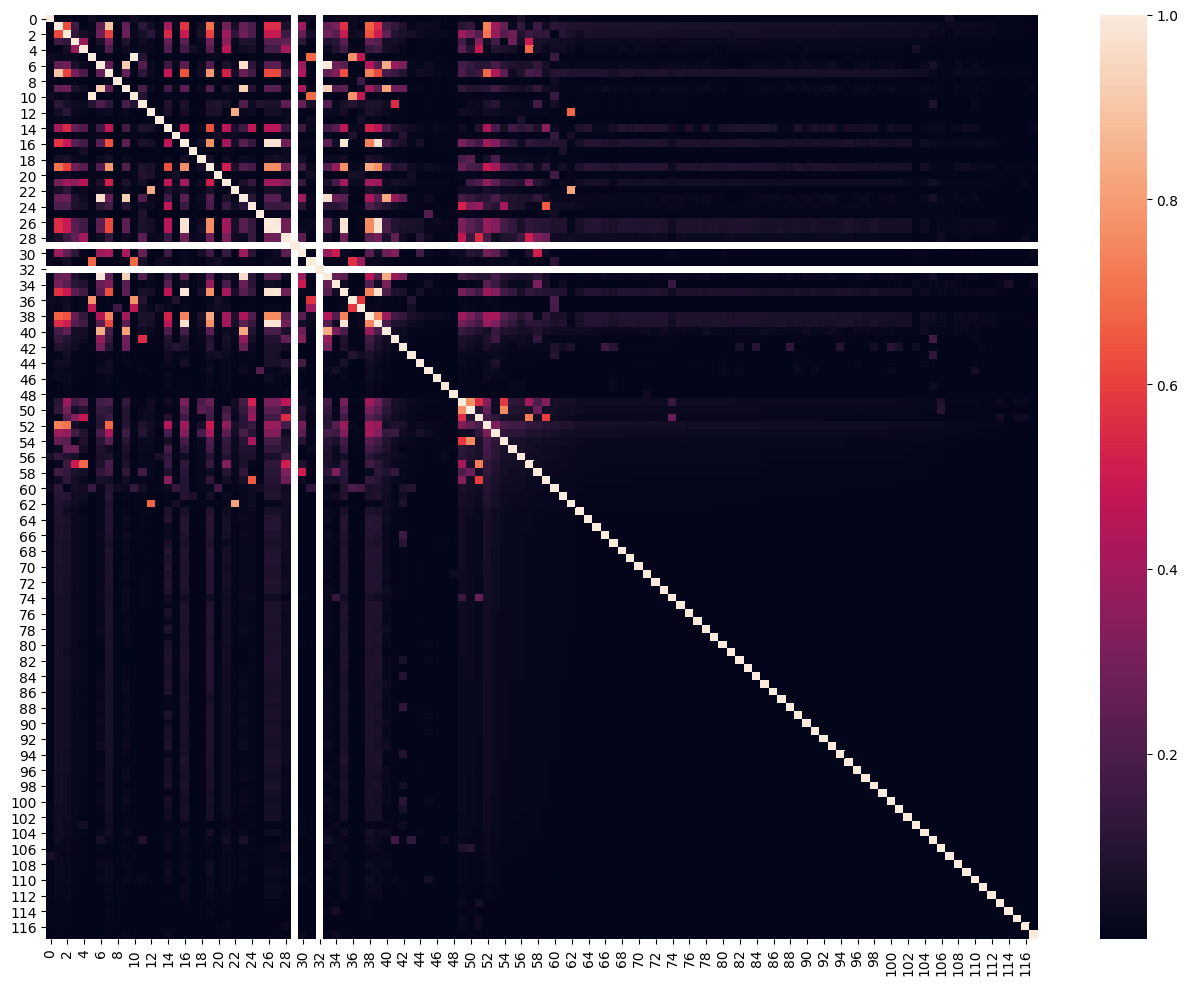

In [114]:
pcorr = np.array(list(map(abs,r1[0].toArray())))
plt.figure(figsize=(16,12))
sns.heatmap(pcorr)
plt.show()

## Train Test Split

In [115]:
train, test = df.randomSplit([0.75, 0.25], seed=SEED)
print("Training data has {} rows, while testing data has {} rows".format(train.count(), test.count()))

StatementMeta(idssmall, 0, 115, Finished, Available)

Training data has 18955 rows, while testing data has 6237 rows

# Model Training

## Random Forest Classifier

In [116]:
rf = RandomForestClassifier()

StatementMeta(idssmall, 0, 116, Finished, Available)

In [117]:
paramGrid = ParamGridBuilder() \
            .addGrid(rf.numTrees, [50, 100, 200]) \
            .addGrid(rf.maxDepth, [5, 10, 15]) \
            .addGrid(rf.maxBins, [8, 16, 32]) \
            .build()

StatementMeta(idssmall, 0, 117, Finished, Available)

In [118]:
# Train the 5-fold Cross Validator
cvModel = CrossValidator(estimator=Pipeline(stages = [rf]),
            estimatorParamMaps=paramGrid,
            evaluator=MulticlassClassificationEvaluator(),
            numFolds=5).fit(train)

StatementMeta(idssmall, 0, 118, Finished, Available)

In [119]:
# best params
print("Best Params:")
hyperparams = cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)]
for i in hyperparams:
    param_name = str(i).split("_")[-1]
    print("{} = {}".format(param_name, hyperparams[i]))

StatementMeta(idssmall, 0, 119, Finished, Available)

Best Params:
numTrees = 50
maxDepth = 10
maxBins = 32

In [120]:
# helper function
def evaluate(predsAndLabels):
    log = {}

    evaluator = BinaryClassificationEvaluator()
    # Validation Score (AUROC)
    log['AUROC'] = "%f" % evaluator.evaluate(predsAndLabels,
                              {evaluator.metricName: "areaUnderROC"})
    # Validation Score (AUPR)
    log['AUPR'] = "%f" % evaluator.evaluate(predsAndLabels,
                              {evaluator.metricName: "areaUnderPR"})
    
    print("Area under ROC = {}".format(log['AUROC']))
    print("Area under PR = {}".format(log['AUPR']))

    # Overall statistics
    evaluator = MulticlassClassificationEvaluator()

    log['Accuracy'] = "%f" % evaluator.evaluate(predsAndLabels,
                              {evaluator.metricName: "accuracy"})
    print("Accuracy = {}".format(log['Accuracy']))

    log['F1 Measure'] = "%f" % evaluator.evaluate(predsAndLabels,
                              {evaluator.metricName: "f1"})
    log['precision'] = "%f" % evaluator.evaluate(predsAndLabels,
                              {evaluator.metricName: "weightedPrecision"}) 
    log['recall'] = "%f" % evaluator.evaluate(predsAndLabels,
                              {evaluator.metricName: "weightedRecall"})
    
    print("[Overall]\tprecision = %s | recall = %s | F1 Measure = %s" % \
            (log['precision'], log['recall'], log['F1 Measure']))

    return log

StatementMeta(idssmall, 0, 120, Finished, Available)

In [121]:
paramMap = cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)]
tunedModel = rf.fit(train, paramMap)

StatementMeta(idssmall, 0, 121, Finished, Available)

In [122]:
predictionAndLabels = tunedModel.transform(train)
trainLog = evaluate(predictionAndLabels)

StatementMeta(idssmall, 0, 122, Finished, Available)

Area under ROC = 0.999922
Area under PR = 0.999916
Accuracy = 0.996413
[Overall]	precision = 0.996427 | recall = 0.996413 | F1 Measure = 0.996412

In [123]:
predictionAndLabels = tunedModel.transform(test)
testLog = evaluate(predictionAndLabels)

StatementMeta(idssmall, 0, 123, Finished, Available)

Area under ROC = 0.999743
Area under PR = 0.999740
Accuracy = 0.992785
[Overall]	precision = 0.992824 | recall = 0.992785 | F1 Measure = 0.992783